In [2]:
# necessary imports for the lab
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display
import os
import numpy as np

# I. Acquisition, Loading and Saving

**1) Capture a video where there is a moving object with a stable camera. We should NOT have access to a sequence where there are no moving objects.**

**a/ Load the video using the VideoCapture function of OpenCV.**

In [2]:
video = cv2.VideoCapture("original.mov")

**b/ Find the appropriate function and display information about the video: height, width, number of frames, and frames per second (fps).**

In [3]:
fps = video. get(cv2.CAP_PROP_FPS)
width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT) 
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT) 
print("fps: ",int(fps))
print("video width: ",int(width))
print("video height: ",int(height))
print("number of frames: ",int(frame_count))

fps:  30
video width:  720
video height:  1280
number of frames:  142


**2) Use the "read" function to extract frames from your video. Then, save them to the working directory using the "imwrite" function (add some frames with numbers to your report).**

In [4]:
video = cv2.VideoCapture("original.mov")
count = 1

while True:
    success, image = video.read()
    if success:
        image = cv2.resize(image,(368,640))
        cv2.imwrite(f"frames/frame{count}.jpg", image)
        count += 1
    else:
        break

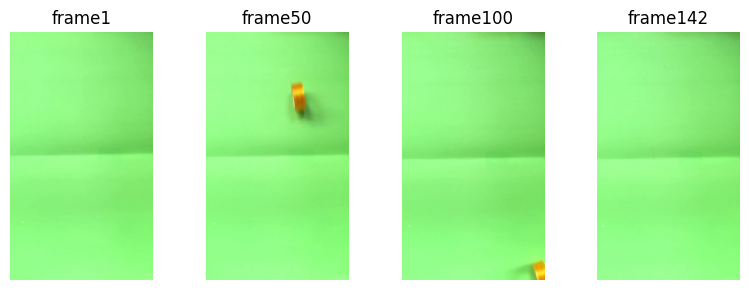

In [5]:
image_paths = ['frames/frame1.jpg', 'frames/frame50.jpg', 'frames/frame100.jpg', 'frames/frame142.jpg']

fig, axs = plt.subplots(1, 4, figsize=(8, 3))

for i in range(4):
    if len(image_paths) > 0:
        path = image_paths.pop(0)
        img = mpimg.imread(path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(os.path.basename(path)[:-4])
    else:
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

**3) Display one frame every 50ms with imshow**

In [6]:
video = cv2.VideoCapture("original.mov")

while True:
    success, frame = video.read()
    
    if success:
        frame = cv2.resize(frame, (368, 640))
        cv2.imshow('Our video', frame)
    else:
        break
    if cv2.waitKey(50) & 0xFF == 'q':
        break

video.release()
cv2.destroyAllWindows()

# II. Spatial Segmentation: Conversion and Thresholding

**Q1**

In [7]:
video = cv2.VideoCapture("original.mov")
count = 1

while True:
    success, frame = video.read()
    
    if success:
        frame = cv2.resize(frame, (368, 640))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        cv2.imshow('Grayscale Video', gray)
        cv2.imwrite(f"gray frames/frame{count}.jpg", gray)
        count += 1
        
    else:
        break
        
    if cv2.waitKey(30) & 0xFF == 'q':
        break

video.release()
cv2.destroyAllWindows()

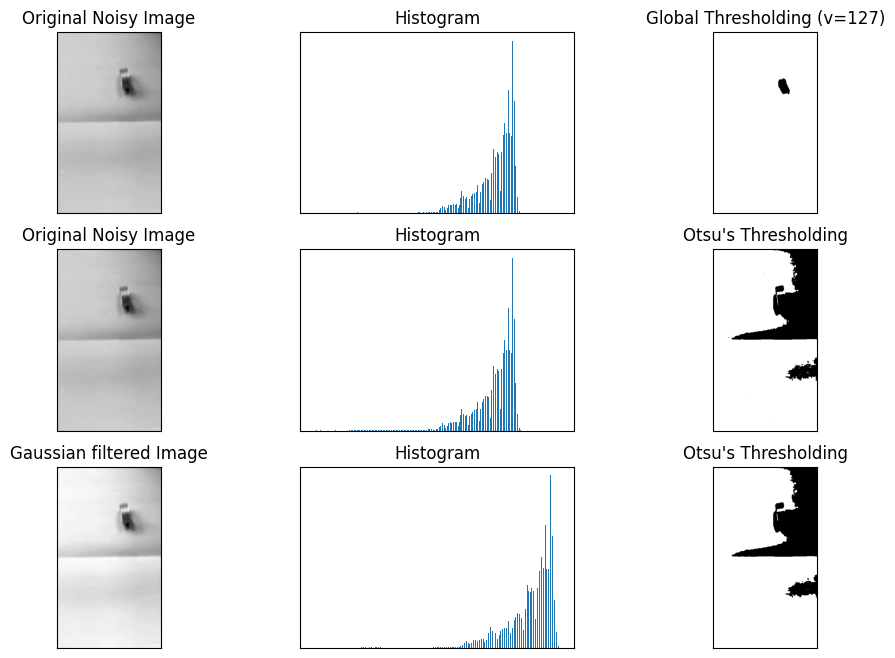

In [8]:
img = cv2.imread('frames/frame50.jpg', cv2.IMREAD_GRAYSCALE)

# global thresholding
_,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
_,th2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
_,th3 = cv2.threshold(blur,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Set the figure size
plt.figure(figsize=(12, 8))

# plot all the images and their histograms
images = [img, 0, th1,
 img, 0, th2,
 blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
 'Original Noisy Image','Histogram',"Otsu's Thresholding",
 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
 plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
 plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
 plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
 plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

Otsu's thresholding appears to be very sensible for shadows in the background and that's why the global thresholding gave us a much more accurate segmentation.

# III. Temporal Segmentation

In [3]:
# Utility function
def display_frames(frames, frame_indices, grid_shape=(2, 2)):

    fig, axes = plt.subplots(*grid_shape, figsize=(10, 10))
    for i, idx in enumerate(frame_indices):
        row = i // grid_shape[1]
        col = i % grid_shape[1]
        axes[row, col].imshow(frames[idx], cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Frame {idx+1}")

    for i in range(len(frame_indices), grid_shape[0] * grid_shape[1]):
        row = i // grid_shape[1]
        col = i % grid_shape[1]
        axes[row, col].axis('off')

    plt.show()

**Q1: Start by implementing the image subtraction method for t-1: This is the basic method for estimating the background image.**

In [13]:
video = cv2.VideoCapture("original.mov")
previousframe = cv2.imread('frames/frame1.jpg', cv2.IMREAD_GRAYSCALE)
previousframe = cv2.GaussianBlur(previousframe,(3,3),cv2.BORDER_DEFAULT, 0)

captured_frames = []

while True:
    
    ret, frame = video.read()
    if not (ret):
        break
        
    frame = cv2.resize(frame,(368,640))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame,(3,3),cv2.BORDER_DEFAULT, 0)
    diff = np.abs(previousframe-frame)
    _, diff = cv2.threshold(diff, 127, 255, cv2.THRESH_BINARY)

    cv2.imshow("T-1 image substraction", diff)
    
    captured_frames.append(diff)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    previousframe = frame
cv2.destroyAllWindows()
video.release()

Trying the subtraction of the images before the thresholding results in a lot of noise in the frames and even applying gaussian blurring like the example below does not solve the problem. So from now on we'll threshold each image first and then apply the subtraction.

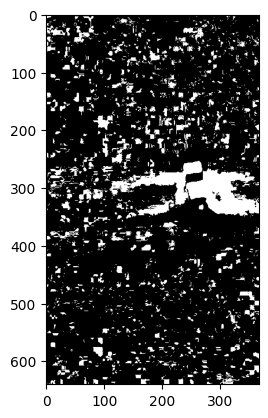

In [14]:
previousframe = cv2.imread('frames/frame61.jpg', cv2.IMREAD_GRAYSCALE)
previousframe = cv2.GaussianBlur(previousframe,(3,3),cv2.BORDER_DEFAULT, 0)

frame = cv2.imread('frames/frame62.jpg', cv2.IMREAD_GRAYSCALE)
frame = cv2.GaussianBlur(frame,(3,3),cv2.BORDER_DEFAULT, 0)

diff = np.abs(previousframe-frame)
_, diff = cv2.threshold(diff, 127, 255, cv2.THRESH_BINARY)

plt.imshow(diff, cmap='gray')    
plt.show()

In [18]:
video = cv2.VideoCapture("original.mov")
bg = cv2.imread('frames/frame1.jpg', cv2.IMREAD_GRAYSCALE)
captured_frames = []

while True:
    
    ret, frame = video.read()
    if not (ret):
        break
        
    frame = cv2.resize(frame,(368,640))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    _,bg = cv2.threshold(bg,127,255,cv2.THRESH_BINARY)
    _,frame = cv2.threshold(frame,127,255,cv2.THRESH_BINARY)

    diff = np.abs(bg-frame)
    _, diff = cv2.threshold(
        diff, 0, 255, cv2.THRESH_BINARY)

    cv2.imshow("T-1 image substraction", diff)
    captured_frames.append(diff)
    bg = frame

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
video.release()

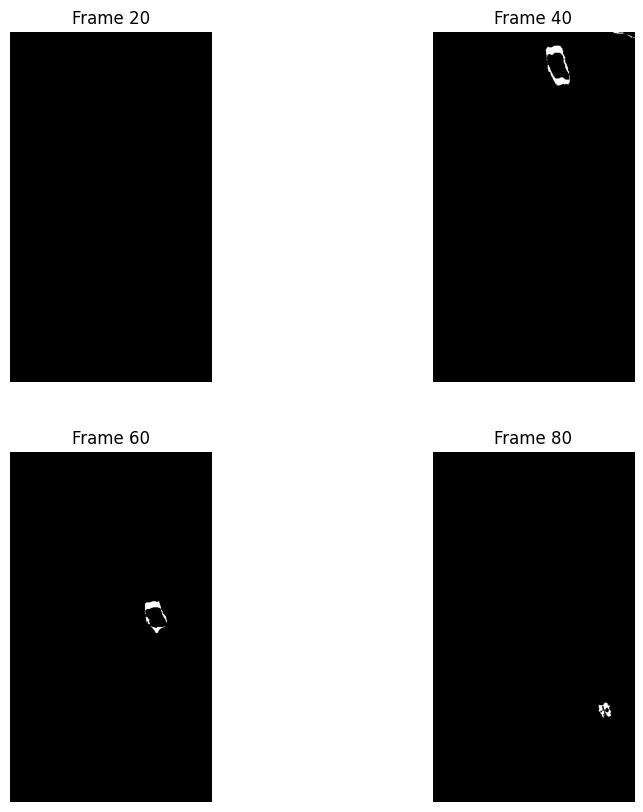

In [19]:
selected_indices = [19, 39, 59, 79]
display_frames(captured_frames, selected_indices)

As we see, the result is decent but our object is empty from the inside and we detect only borders due to the nature of this background subtraction technique.

**Q2: 3-frame differentiation**

In [20]:
frames = [cv2.imread(f'frames/frame{i+1}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(142)]
video = cv2.VideoCapture("original.mov")
count = 1
captured_frames = []
n= 1

while True:
    ret, frame = video.read()
    frame = cv2.resize(frame,(368,640))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if not ret:
        break
    else:           
        if count < n+1:
            pass
        if count > 142- n:
            break
            cv2.destroyAllWindows()
            video.release()
        else:
            _, past_frame = cv2.threshold(frames[count-n-1], 127, 255, cv2.THRESH_BINARY)
            _, current_frame = cv2.threshold(frame, 127, 255, cv2.THRESH_BINARY)
            _, future_frame = cv2.threshold(frames[count+n-1], 127, 255, cv2.THRESH_BINARY)

            _, past_current = cv2.threshold(np.abs(past_frame-frame), 127, 255, cv2.THRESH_BINARY)
            _, future_current = cv2.threshold(np.abs(future_frame-frame), 127, 255, cv2.THRESH_BINARY)
            sum_frame = cv2.bitwise_and(past_current, future_current)

            count += 1
            captured_frames.append(sum_frame)

            cv2.imshow("3-frame differenciation", sum_frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
video.release()

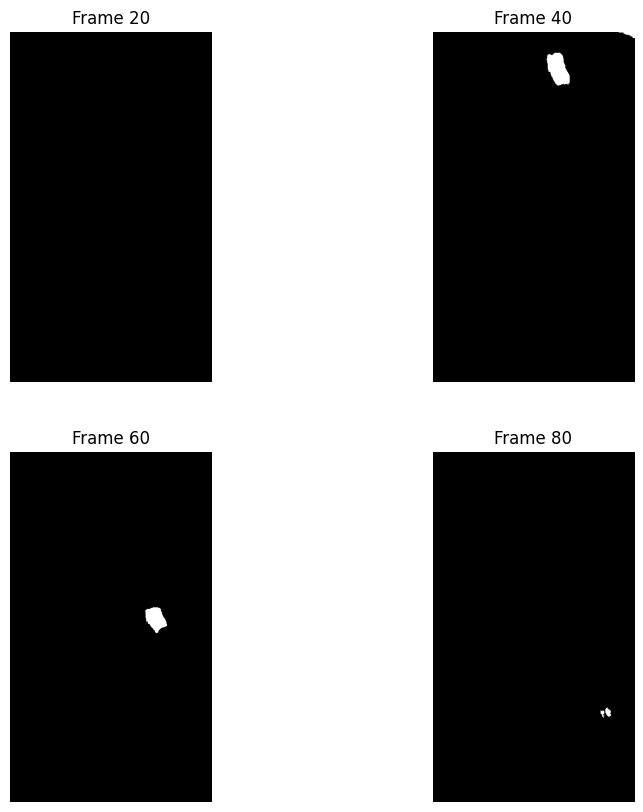

In [21]:
selected_indices = [19, 39, 59, 79]
display_frames(captured_frames, selected_indices)

Our object is slow in the nature and that's why even n=1 is enough to give us an object that is close to the original shape and filled from the inside.

**Q3: Adaptive Background Substraction**

In [4]:
video = cv2.VideoCapture("original.mov")
B = cv2.imread('frames/frame1.jpg',  cv2.IMREAD_GRAYSCALE)
I = cv2.imread('frames/frame1.jpg',  cv2.IMREAD_GRAYSCALE)
captured_frames = []
alpha = 0.2

while True:
    
    ret, frame = video.read()
    if not (ret):
        break
        
    frame = cv2.resize(frame,(368,640))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _,frame = cv2.threshold(frame,127,255,cv2.THRESH_BINARY)

    
    BG = alpha*B + (1-alpha)*I
    _,BG = cv2.threshold(BG,127,255,cv2.THRESH_BINARY)
        
    diff = np.abs(BG-frame)

    cv2.imshow("Adaptive Background Subtraction", diff)
    B = BG
    I = frame
    captured_frames.append(diff)
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
video.release()

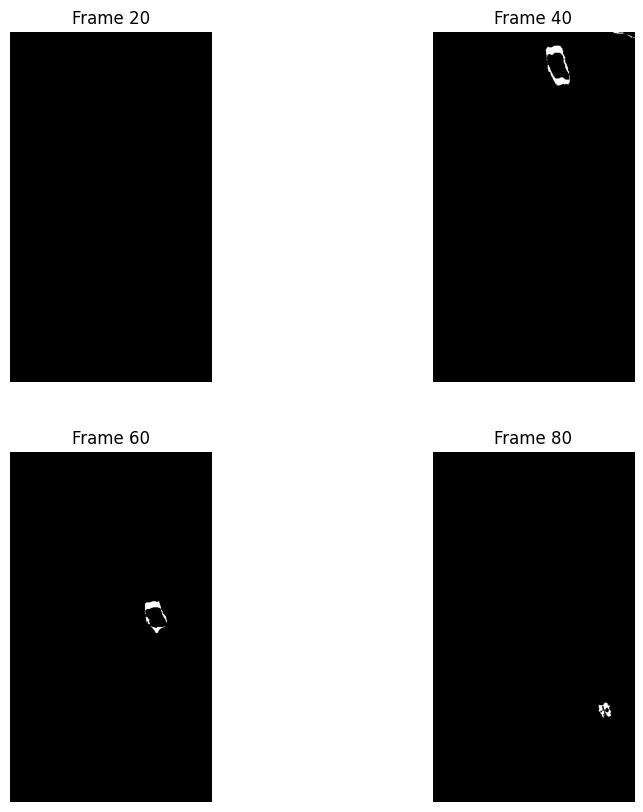

In [5]:
selected_indices = [19, 39, 59, 79]
display_frames(captured_frames, selected_indices)

**Q4: With opencv, you can use background estimation and subtraction methods different from those seen in class. For this last question, you are asked to identify two of these methods, briefly explain how they work and show the results of their application on your video, including your comments as always.**

**BackgroundSubtractorMOG**

It is a Gaussian Mixture-based Background/Foreground Segmentation Algorithm. It was introduced in the paper "An improved adaptive background mixture model for real-time tracking with shadow detection" by P. KadewTraKuPong and R. Bowden in 2001. It uses a method to model each background pixel by a mixture of K Gaussian distributions (K = 3 to 5). The weights of the mixture represent the time proportions that those colours stay in the scene. The probable background colours are the ones which stay longer and more static.

While coding, we need to create a background object using the function, cv2.createBackgroundSubtractorMOG(). It has some optional parameters like length of history, number of gaussian mixtures, threshold etc. It is all set to some default values. Then inside the video loop, use backgroundsubtractor.apply() method to get the foreground mask.

In [85]:
video = cv2.VideoCapture("original.mov")

mog_bg_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
captured_frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, (368, 640))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    mog_mask = mog_bg_subtractor.apply(frame_gray)
    captured_frames.append(mog_mask)

    cv2.imshow("MOG Background Subtraction", mog_mask)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
video.release()

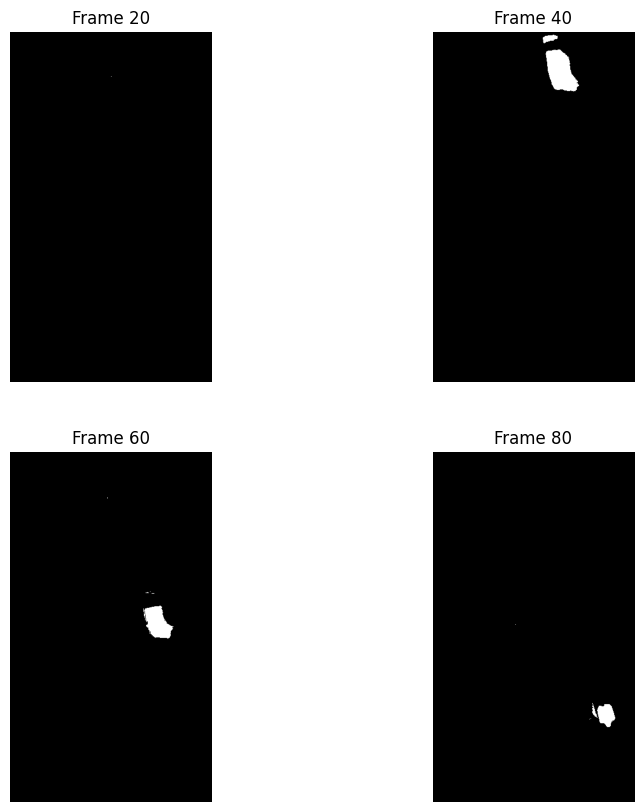

In [86]:
selected_indices = [19, 39, 59, 79]
display_frames(captured_frames, selected_indices)

**BackgroundSubtractorMOG2**

It is also a Gaussian Mixture-based Background/Foreground Segmentation Algorithm. It is based on two papers by Z.Zivkovic, "Improved adaptive Gausian mixture model for background subtraction" in 2004 and "Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction" in 2006. One important feature of this algorithm is that it selects the appropriate number of gaussian distribution for each pixel. (Remember, in last case, we took a K gaussian distributions throughout the algorithm). It provides better adaptibility to varying scenes due illumination changes etc.

As in previous case, we have to create a background subtractor object. Here, you have an option of selecting whether shadow to be detected or not. If detectShadows = True (which is so by default), it detects and marks shadows, but decreases the speed. Shadows will be marked in gray color.

In [87]:
video = cv2.VideoCapture("original.mov")

mog2_bg_subtractor = cv2.createBackgroundSubtractorMOG2()
captured_frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, (368, 640))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    mog2_mask = mog2_bg_subtractor.apply(frame_gray)
    captured_frames.append(mog2_mask)

    cv2.imshow("MOG2 Background Subtraction", mog2_mask)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
video.release()

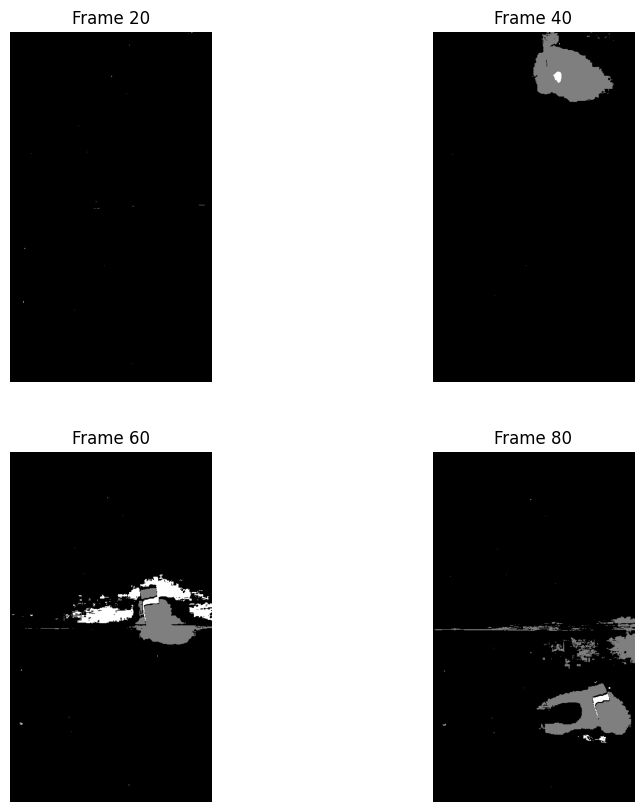

In [88]:
selected_indices = [19, 39, 59, 79]
display_frames(captured_frames, selected_indices)

As noticed MOG2 background subtractor is much more sensible to shadows and noise.